# Extracting TD Bank Statement Expenses #

1. Download data
    - manually get data from bank account
            - download in order from January to December
            - rename files once downloaded using for loop

2. Preprocess the data
    - transform data into pandas dataframe
    - clean and organize
    - change data type for 'Date' column

3. Export the data
    - export the dataframe into sheets
        - use a for loop to iterate. Use the length of number of PDFs in the folder
        - use if statement to check whether or not sheet already exists

4. Visualize the data in Python or Excel
    - create bar graphs for each month
    - create line/scatter plot with daily usage
        - automate using VBA

*Note: This script was made specifically for TD Bank users.*


Import Libraries

In [141]:
# Libraries
import tabula
from tabula import read_pdf
from tabulate import tabulate
import glob
import os
import pandas as pd

# Check if files exist and rename according to month
# Note: Download file by month order. Makes renaming easier.
month_name = ['jan','feb','march','april','may','june','october','august','sept','oct','nov','dec']
i = 0
files = glob.glob('*.pdf')
files.sort(key=lambda x: os.path.getmtime(x))   # Sorts files in order of download. Useful for proper renaming

if os.path.exists('jan2022.pdf') is False:
    for file in files:
        new_file_name = month_name[i]+'2021.pdf'
        os.rename(files[i],new_file_name)
        i+=1
else:
    print('PDFs have already been renamed.')

PDFs have already been renamed.


Import Bank Statement PDFs

In [142]:
# Retrieve PDF statement paths in order
files = glob.glob('*.pdf')
files.sort(key=lambda x: os.path.getmtime(x))   # sorts files by modified/downloaded dates
type(files)
print(files)


['jan2022.pdf', 'feb2022.pdf', 'march2022.pdf', 'april2022.pdf', 'may2022.pdf', 'june2022.pdf', 'july2022.pdf', 'august2022.pdf', 'sept2022.pdf', 'oct2022.pdf', 'nov2022.pdf', 'dec2022.pdf']


Monthly Expenses and Deposits

In [143]:
# Get the monthly expenses (withdrawls) and deposits
months=[]
for file in files:
    statement = tabula.read_pdf(file,pages='all')   # finds all the tables
    index = list(range(len(statement))) # gets a list of the number of tables in the statement

    # Monthly Withdrawals & Deposits
    monthly = pd.DataFrame()
    for i in index:
        if statement[i].columns.any() == 'Description':  # Used boolean to verify
            new = statement[i].iloc[:,:].tail(1)  # Gets all columns of the last row
            monthly = pd.concat([monthly,new], ignore_index=True)
        elif i == index[-1]:
            monthly = monthly.drop(['Balance','Description','Date'],axis=1).fillna(0) # Some desposits actually named 'Unnamed: 0'.
            # drop 'Balance' to cover personal information.
            monthly['Deposits'] = monthly['Deposits'].replace(',','',regex=True).astype(float)    # had data as strings
            monthly['Withdrawals'] = monthly['Withdrawals'].replace(',','',regex=True).astype(float)

            if monthly.columns.str.contains('^Unnamed').any() == True: # must use this specific method to find the Unnamed: 0 column
                monthly['Deposits'] = monthly['Deposits'] +monthly['Unnamed: 0']
                monthly = monthly.drop('Unnamed: 0',axis=1)
                months.append(monthly)
            else:
                months.append(monthly)
        else:
            continue

Monthly Daily Transactions

In [144]:
# Get Monthly Daily Transactions
daily=[]
for file in files:
    statement = tabula.read_pdf(file,pages='all')   # finds all the tables
    index = list(range(len(statement))) # gets a list of the number of tables in the statement

    # Daily Withdrawals & Deposits
    days = pd.DataFrame()
    for i in index:
        if statement[i].columns.any() == 'Description':  # Used boolean to verify
            new = statement[i].iloc[:,:]  # Gets all the rows and columns of the transaction tables
            new = new.drop(new.head(1).index, axis=0)   # drops the first row of each  table since it gives the starting balance
            new = new.drop(new.tail(1).index, axis=0)   # drops the last row of each table since it gives the total
            days = pd.concat([days,new],ignore_index=True)
        elif i == index[-1]:
            days['Deposits'] = days['Deposits'].replace(',','',regex=True).astype(float)    # data as strings
            days['Withdrawals'] = days['Withdrawals'].replace(',','',regex=True).astype(float)
            days = days.drop(['Balance'],axis=1)
            days = days.fillna(0)
            if days.columns.str.contains('^Unnamed').any() == True: # must use this specific method to find the Unnamed: 0 column
                '''days = days.drop('Unnamed: 0',axis=1) # can't drop Unnamed: 0 with this method'''
                days['Deposits'] = days['Deposits'] +days['Unnamed: 0']
                days = days.drop('Unnamed: 0',axis=1)
                daily.append(days)
            # keep 'Balance' but for personal use.
            else:
                daily.append(days)
        else:
            continue

Change Data type of 'Date' Column

In [ ]:
import datetime
for the_month in daily:
    for i in range(the_month.shape[0]):
        change_date = the_month['Date'].iloc[i]
        change_date = change_date[:3].lower() + '/' + str(int(change_date[3:])) +'/2022'
        format = "%b/%d/%Y"
        the_month['Date'].iloc[i] = datetime.datetime.strptime(change_date,format)

In [146]:
# October
october = daily[9].copy()
october['Date'] = pd.to_datetime(october['Date'])
october = october.groupby('Date').sum('Withdrawls')

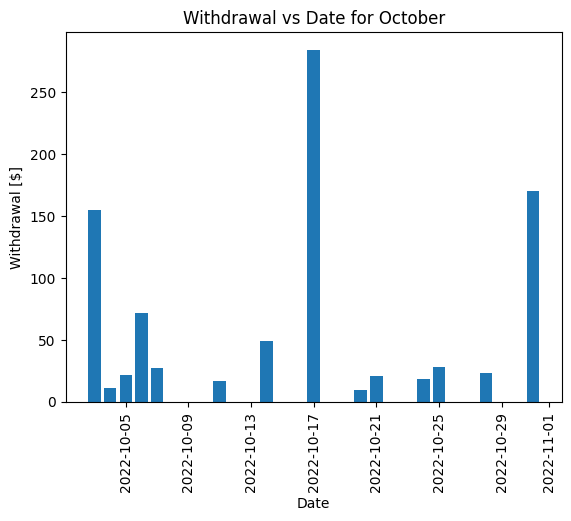

In [147]:
# Withdrawals of the October
import matplotlib.pyplot as plt
plt.title('Withdrawal vs Date for October')
plt.bar(october.index,october['Withdrawals'])
plt.xlabel('Date')
plt.ylabel('Withdrawal [$]')
plt.xticks(rotation='vertical')
plt.show()

Combine Monthly Daily Transcations into a Single Dataframe

In [148]:
all_monthly_daily = pd.DataFrame()
for day in daily:
    all_monthly_daily = pd.concat([all_monthly_daily,day])
# all_monthly_daily

In [149]:
total = all_monthly_daily.groupby('Date').sum('Withdrawals')

In [ ]:
# Withdrawals of the Year
import matplotlib.pyplot as plt
plt.figure(figsize=(9,5))
plt.title('Withdrawal vs Date for 2022')
plt.plot(total['Withdrawals'])
plt.xlabel('Date')
plt.ylabel('Withdrawal [$]')
plt.xticks(rotation='vertical')
plt.show()

Export as Excel file

In [151]:
# Another technique to get month names
sheets = []
for file in files:
    sheet = os.path.basename(file)
    sheet = sheet.split("2")[0]
    sheets.append(sheet)
print(sheets)
# Or just use month_name from earlier in the notebook

['jan', 'feb', 'march', 'april', 'may', 'june', 'july', 'august', 'sept', 'oct', 'nov', 'dec']


In [152]:
 # Won't overwrite
 # Export Monthly Daily transactions into a single excel with sheet corresponding to each month
if os.path.exists('monthly_daily2022.xlsx') is False:
    i=0
    with pd.ExcelWriter('monthly_daily2022.xlsx') as writer:
        for sheet in sheets:
            daily[i].to_excel(writer,sheet_name=sheet,index=False)
            i+=1
else:
    print("Done")

In [153]:
if os.path.exists('Total_Expenses2022.xlsx') is False:
    i=0
    with pd.ExcelWriter('Total_Expenses.xlsx') as writer:
        all_monthly_daily.to_excel(writer,sheet_name='Expenses2022',index=False)
else:
    print("Done")